### Импорт библиотек

In [1]:
# data anlysis
import numpy as np
import pandas as pd

# data visualization
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# data preparation for modelling
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# Artificial Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Dropout, AlphaDropout
from tensorflow.keras.optimizers import SGD, RMSprop, Adamax, Adagrad, Adam, Nadam
from eli5.sklearn import PermutationImportance

from tqdm import tqdm

np.random.seed(42)

C:\Users\Dmitry\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Dmitry\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Подгрузим оффициальные данные

In [2]:
# load train and test data
train = pd.read_csv('data/kaggle/train.csv')
test = pd.read_csv('data/kaggle/test.csv')

TRAIN_SIZE = len(train['Survived'])

# merge train and test data for common data processingg
data = pd.concat([train, test], axis=0, ignore_index=True)

### Feature Engineering

Создание категорий по возрасту, дети выживают чаще

In [3]:
train["AgeCat"]= pd.cut(train["Age"], bins=[0,15,max(train["Age"]+1)], labels=['child','adult'])

Создание категорий по расходам на билеты. Посколку настоящие расходы не известны, а только на семью, объединим информацию по группам.

In [4]:
# the code below finds person groups which share the same tickets and 
# devides the ticket fare by the number of people in the group
train['FareCorr'] = train['Fare'].copy()

m=0 # m=0 -> print first iteration as example how the code works
for grp, grp_df in train[['Ticket', 'Name', 'Pclass', 'Fare', 'PassengerId']].groupby(['Ticket']):

    if (len(grp_df) != 1):
        if m==0:
            print(grp_df)
            m=1
        for ind, row in grp_df.iterrows():
            passID = row['PassengerId']
            train.loc[train['PassengerId'] == passID, 'FareCorr'] = train['Fare'][train['PassengerId'] == passID]/len(grp_df)

train['FareCat']=pd.cut(train['FareCorr'], bins=[0,15,65,max(train["FareCorr"]+1)], labels=['low','mid','high'])

     Ticket                                               Name  Pclass  Fare  \
257  110152                               Cherry, Miss. Gladys       1  86.5   
504  110152                              Maioni, Miss. Roberta       1  86.5   
759  110152  Rothes, the Countess. of (Lucy Noel Martha Dye...       1  86.5   

     PassengerId  
257          258  
504          505  
759          760  


Вытащим из имен титулы. Титулы могут характеризовать положение в обществе и потенциальный возраст человека, а это особенно важно, поскольку в графе возраста очень много пропусков.

In [5]:
# extracting the Title (which always ends with a ".")
for name_string in data['Name']:
    data['Title'] = data['Name'].str.extract('([A-Za-z]+)\.', expand=True)

#transform titles which are synonyms
data['Title']=data['Title'].replace({'Ms':'Miss','Mlle':'Miss','Mme':'Mrs'})

# Noble passengers
data['Title']=data['Title'].replace(['Sir','Don','Dona','Jonkheer','Lady','Countess'], 'Noble')

# passengers with a higher social standing
data['Title']=data['Title'].replace(['Dr', 'Rev','Col','Major','Capt'], 'Others')

data['Title'].value_counts()

Mr        757
Miss      264
Mrs       198
Master     61
Others     23
Noble       6
Name: Title, dtype: int64

Заполним пропуски в возрасте основываясь на титуле, возрасте похожих по титулу людей.

In [6]:
title_list=data.groupby('Title')['Age'].median().index.to_list()
# Filling missing age values 
for title in title_list:
    if title=='Miss':
        # Miss with Parch = 0 and missing age value: set median age >15 to missing values
        data.loc[(data['Age'].isnull()) & (data['Title'] == title) & (data['Parch'] == 0), 'Age'] \
        = data['Age'][(data['Title']== title) & (data['Age']>=15)].median()
        
        # Miss with Parch > 0 and missing age value: set median age <15 to missing values
        data.loc[(data['Age'].isnull()) & (data['Title'] == title) & (data['Parch'] > 0), 'Age'] \
        = data['Age'][(data['Title']== title) & (data['Age']<15)].median()
        
        # all Misses with Age < 15: set Title to youngMiss 
        data.loc[(data['Age']<15) & (data['Title'] == title), 'Title'] \
        = 'youngMiss'    
                                                 
    else: 
        data.loc[(data['Age'].isnull()) & (data['Title'] == title), 'Age'] \
        = data['Age'][(data['Title']== title)].median()

Поскольку мы заполнили величину возраста похожими на ground true величинами, но не абсолютно точными, объединим людей в возрастные группы.

In [7]:
# We split the feature Age in five categories, where category 1 refers to children (age<15)
data["AgeCat"]= pd.cut(data["Age"], bins=[0,14.9,30,45,60,max(data["Age"]+1)], labels=['1','2','3','4','5'])

# size of each category
data['AgeCat'].value_counts()

2    717
3    309
1    127
4    123
5     33
Name: AgeCat, dtype: int64

Создадим категории отвечающие за размер семьи на борту

In [8]:
# create feature FamilySize
data.loc[data['SibSp'] + data['Parch'] + 1 == 1, 'FamilySize'] = 'Single'
data.loc[data['SibSp'] + data['Parch'] + 1 > 1 , 'FamilySize'] = 'Small'
data.loc[data['SibSp'] + data['Parch'] + 1 > 4 , 'FamilySize'] = 'Big'

In [9]:
# extract last names
#data['Last_Name'] = data['Name'].apply(lambda x: str.split(x, ",")[0])
data['Last_Name'] =  data['Name'].str.extract('([A-Za-z]+),', expand=True)
data['Last_Name'].value_counts()
#data.groupby('Last_Name')

Andersson    11
Sage         11
Goodwin       8
Asplund       8
Davies        7
             ..
Payne         1
Gallagher     1
Shawah        1
Brady         1
Mockler       1
Name: Last_Name, Length: 872, dtype: int64

Попытаемся ввести дополнительную информацию из трейна через фамилии людей, есть ли погибшие среди их семьи

In [11]:
data['Last_Name'] = data['Name'].apply(lambda x: str.split(x, ",")[0])
default_value = 0.5

data['FamilySurvival'] = default_value
for grp, grp_df in data[['Survived', 'Last_Name', 'Ticket', 'PassengerId']].groupby(['Last_Name']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data.loc[data['PassengerId'] == passID, 'FamilySurvival'] = 1
            elif (smin == 0.0):
                data.loc[data['PassengerId'] == passID, 'FamilySurvival'] = 0
    
for _, grp_df in data.groupby('Ticket'):
    if (len(grp_df) != 1):
        #print(grp_df)
        for ind, row in grp_df.iterrows():
            if (row['FamilySurvival'] == 0) | (row['FamilySurvival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data.loc[data['PassengerId'] == passID, 'FamilySurvival'] = 1
                elif (smin == 0.0):
                    data.loc[data['PassengerId'] == passID, 'FamilySurvival'] = 0

data['FamilySurvival'].value_counts()    

0.5    656
1.0    376
0.0    277
Name: FamilySurvival, dtype: int64

In [12]:
data['FareCorr'] = data['Fare'].copy()

for grp, grp_df in data[['Ticket','Name', 'Pclass', 'Fare', 'PassengerId']].groupby(['Ticket']):

    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            passID = row['PassengerId']
            data.loc[data['PassengerId'] == passID, 'FareCorr'] = data['Fare'][data['PassengerId'] == passID]/len(grp_df)

In [13]:
fa = data[data["Pclass"] == 3]
data['FareCorr'].fillna(fa['FareCorr'].median(), inplace = True)
# data.info()

In [57]:
pd.qcut(data['FareCorr'], 7).unique()

[(7.0, 7.75], (27.721, 128.082], (7.75, 7.925], (13.0, 27.721], (7.925, 9.588], (-0.001, 7.0], (9.588, 13.0]]
Categories (7, interval[float64]): [(-0.001, 7.0] < (7.0, 7.75] < (7.75, 7.925] < (7.925, 9.588] < (9.588, 13.0] < (13.0, 27.721] < (27.721, 128.082]]

In [14]:
data['FareCat']=pd.qcut(data['FareCorr'], 7, labels=['1','2','3','4','5','6','7'])
data['FareCat'].value_counts()

2    236
5    212
1    188
7    186
4    167
6    162
3    158
Name: FareCat, dtype: int64

In [15]:
data['Embarked'].fillna('C', inplace = True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   PassengerId     1309 non-null   int64   
 1   Survived        891 non-null    float64 
 2   Pclass          1309 non-null   int64   
 3   Name            1309 non-null   object  
 4   Sex             1309 non-null   object  
 5   Age             1309 non-null   float64 
 6   SibSp           1309 non-null   int64   
 7   Parch           1309 non-null   int64   
 8   Ticket          1309 non-null   object  
 9   Fare            1308 non-null   float64 
 10  Cabin           295 non-null    object  
 11  Embarked        1309 non-null   object  
 12  Title           1309 non-null   object  
 13  AgeCat          1309 non-null   category
 14  FamilySize      1309 non-null   object  
 15  Last_Name       1309 non-null   object  
 16  FamilySurvival  1309 non-null   float64 
 17  FareCorr      

### Подготовка информации к моделированию

In [17]:
data_pre = data.drop(['Embarked','Survived','PassengerId','Name','Age','Parch','SibSp','Ticket','Fare','Cabin','Last_Name','FareCorr'],axis=1)

In [18]:
data_pre

,Pclass,Sex,Title,AgeCat,FamilySize,FamilySurvival,FareCat
0,3,male,Mr,2,Small,0.0,2
1,1,female,Mrs,3,Small,0.5,7
2,3,female,Miss,2,Single,0.5,3
3,1,female,Mrs,3,Small,0.0,6
4,3,male,Mr,3,Single,1.0,4
...,...,...,...,...,...,...,...
1304,3,male,Mr,2,Single,0.5,4
1305,1,female,Noble,3,Single,1.0,7
1306,3,male,Mr,3,Single,0.5,2
1307,3,male,Mr,2,Single,0.5,4


In [19]:
oneHot=OneHotEncoder()
data_post=oneHot.fit_transform(data_pre)

feature_names = oneHot.get_feature_names(data_pre.columns)
feature_names

array(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Noble', 'Title_Others', 'Title_youngMiss', 'AgeCat_1',
       'AgeCat_2', 'AgeCat_3', 'AgeCat_4', 'AgeCat_5', 'FamilySize_Big',
       'FamilySize_Single', 'FamilySize_Small', 'FamilySurvival_0.0',
       'FamilySurvival_0.5', 'FamilySurvival_1.0', 'FareCat_1',
       'FareCat_2', 'FareCat_3', 'FareCat_4', 'FareCat_5', 'FareCat_6',
       'FareCat_7'], dtype=object)

In [21]:
# training data
X_train = data_post[:TRAIN_SIZE,:].toarray()
y_train = train['Survived'].copy().to_numpy()   # traget

# test data
X_test = data_post[TRAIN_SIZE:,:].toarray()

In [22]:
# check shape of X_train - number of instances and features
print('# instances: '+ str(X_train.shape[0]))
print('# features: '+ str(X_train.shape[1]))

# instances: 891
# features: 30


### Cоздание базовой модели

In [23]:
# define functions
def hyperparameter_analysis(searcher, top_values=5):
    tested_hyperparameters=pd.DataFrame()
    for i in range(len(searcher.cv_results_['params'])):
        tested_hyperparameters = tested_hyperparameters.append(searcher.cv_results_['params'][i], ignore_index=True)
    tested_hyperparameters['train score in %']=(searcher.cv_results_['mean_train_score']*100).round(3)
    tested_hyperparameters['test score in %']=(searcher.cv_results_['mean_test_score']*100).round(3)
    tested_hyperparameters['test std in %']=(searcher.cv_results_['std_test_score']*100).round(3)
    tested_hyperparameters.index=searcher.cv_results_['rank_test_score']
    return(tested_hyperparameters.sort_index().head(top_values))


def metric_scores(y_reference, y_prediction):
    accuracy = accuracy_score(y_reference, y_prediction)
    precision = precision_score(y_reference, y_prediction)
    recall = recall_score(y_reference, y_prediction)
    F1_score = f1_score(y_reference, y_prediction)
    print('accuracy:' + str(accuracy.round(3)))
    print('precision: '+ str(precision.round(3)))
    print('recall: '+ str(recall.round(3)))
    print('F1_score: '+ str(F1_score.round(3)))

Создание функции модели для Wrapper'a

In [24]:
def create_model(input_shape=X_train.shape[1:],
                number_hidden=2, 
                neurons_per_hidden=10,
                hidden_drop_rate= 0.2,
                hidden_activation = 'selu',
                hidden_initializer="lecun_normal",
                output_activation ='sigmoid',
                loss='binary_crossentropy',
#                 optimizer = Nadam(lr=0.0005),
                optimizer = Nadam,
                lr=0.0005,
                ):
    
    #create model
    model = Sequential()
    model.add(Input(shape=input_shape)),
    for layer in range(number_hidden):
        model.add(Dense(neurons_per_hidden, activation = hidden_activation ,kernel_initializer=hidden_initializer))
        #model.add(Dropout(hidden_drop_rate))
    model.add(Dense(1, activation = output_activation))

    # Compile model
    model.compile(loss=loss, 
                  optimizer = optimizer(lr=lr), 
#                   optimizer = Nadam(lr=0.0005),
                  metrics = ['accuracy', 'Recall'])
    return model

Обучим базовую нейросеть

In [25]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# build and compile ANN classifier by calling the model function
clf=create_model()

# train the ANN classifier
history = clf.fit(X_train, y_train, epochs=30, batch_size=30, verbose=0)
print(f'Training score: {(np.max((history.history["accuracy"]))*100).round(3)} %')

Training score: 85.073 %


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
accuracy:0.844
precision: 0.828
recall: 0.749
F1_score: 0.786


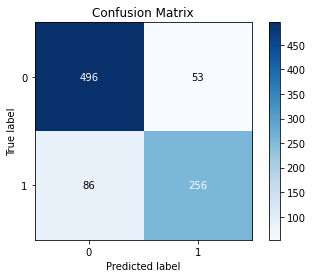

In [26]:
y_train_pred = clf.predict_classes(X_train)
y_test_pred = clf.predict_classes(X_test)

plot_confusion_matrix(y_true=y_train, y_pred = y_train_pred)

metric_scores(y_train, y_train_pred)

### Важность признаков датасета

Обернем функцию модели в оболочку для совместимости с Sklearn

In [27]:
np.random.seed(42)
tf.random.set_seed(42)

# build and train KerasClassifier
keras_clf=KerasClassifier(build_fn = create_model)
keras_clf.fit(X_train, y_train, epochs=30, batch_size=30, verbose=0)

Выполним оценку важности признаков перестановками через PermutationImportance.

In [28]:
# calculate feature importance
permutator = PermutationImportance(keras_clf, random_state=42, scoring = 'accuracy', cv = 'prefit')
permutator.fit(X_train,y_train)

PermutationImportance(estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000000E878892BB0>,
                      random_state=42, scoring='accuracy')

Таблица важности признаков

In [29]:
(pd.DataFrame({'feature':feature_names, 'importance':(permutator.feature_importances_*100).round(3)})
 .sort_values('importance', ascending=False)).head()

,feature,importance
7,Title_Mr,2.088
5,Title_Master,1.661
20,FamilySurvival_0.0,1.414
3,Sex_female,1.324
17,FamilySize_Big,1.100


Выбор лучших признаков по отсечке. Модель должна иметь атрибут feature_importances_.

In [30]:
def select_best_feature(model, combine_data, train_size, number_feature, threshold):
    
    selected = SelectFromModel(model, threshold=threshold, max_features=number_feature, prefit=True)
    best_festures_index=np.where(selected.get_support()==True)

    # create training data with k selected features
    X_train_best_features = combine_data[:train_size, best_festures_index[0]].copy()
    # create test data with k selected features
    X_test_best_features = combine_data[train_size:, best_festures_index[0]].copy()
    return X_train_best_features, X_test_best_features

In [31]:
X_train_best_feature, X_test_best_feature = select_best_feature(model = permutator,
                                                                combine_data = data_post,
                                                                train_size = TRAIN_SIZE,
                                                                number_feature = 17,
                                                                threshold = -np.inf)

### Поиск гиперпараметров по сетке

Выберем датасет для дальнейшего использования его для поиска гиперпараметров по сетке GridSearch

In [32]:
def data_for_gridsearch(best_features = False):
    if not best_features:
        print(f'# of features in dataset: {X_train.shape[1]}')
        return X_train.copy(), X_test.copy()
    else:
        print(f'# of features in dataset: {X_train_best_feature.shape[1]}')
        return X_train_best_feature.copy, X_test_best_feature.copy()

In [33]:
X_train_gridsearch, X_test_gridsearch = data_for_gridsearch(best_features = False)

# of features in dataset: 30


In [34]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# build classifier
keras_grid_search = KerasClassifier(build_fn = create_model, verbose = 0)

# define parameter grid: 
# uncomment the parameters you want to optimize
param_grid = {
#     "optimizer": [SGD, RMSprop, Adamax, Adagrad, Adam, Nadam],
#     "lr":[0.005,0.001,0.0005,0.0001],
#     "epochs": [15, 30, 45, 60],
#     "batch_size": [20,30,40],
#     "number_hidden": [1, 2, 3],
#     "neurons_per_hidden": [5, 10, 15],
    'input_shape': X_train_gridsearch.shape[1:]  # keep this line
}

# build GridSearchCV model with ANN classifier
grid_search = GridSearchCV(keras_grid_search, param_grid, cv=5, n_jobs=-1, verbose=0, return_train_score=True)

# fit GridSearchCV model
grid_search.fit(X_train_gridsearch, y_train,
                epochs = 30, 
                batch_size = 30,
                validation_split=0.2, shuffle=True,
#               callbacks=[keras.callbacks.EarlyStopping(patience=8)]
                )     

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000000E87BF9D9A0>,
             n_jobs=-1, param_grid={'input_shape': (30,)},
             return_train_score=True)

In [35]:
mean_train = (grid_search.cv_results_["mean_train_score"][0]*100).round(3)
std_train = (grid_search.cv_results_["std_train_score"][0]*100).round(3)
mean_test = (grid_search.cv_results_["mean_test_score"][0]*100).round(3)
std_test = (grid_search.cv_results_["std_test_score"][0]*100).round(3)
print(f'Mean train score = {mean_train}%, std = {std_train}%')
print(f'Mean test score = {mean_test}%, std = {std_test}%')

Mean train score = 84.428%, std = 0.776%
Mean test score = 82.603%, std = 2.166%


Кривая обучения модели

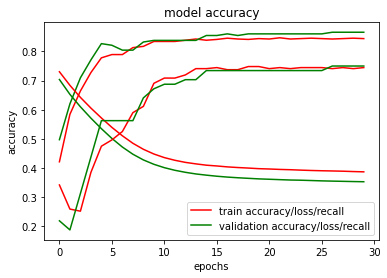

After tuning hyperparameters:
accuracy:0.848
precision: 0.842
recall: 0.746
F1_score: 0.791


Before tuning hyperparameters:
accuracy:0.844
precision: 0.828
recall: 0.749
F1_score: 0.786


In [36]:
def learning_curve(seacher):
    # summarize history for accuracy
    plt.plot(seacher.best_estimator_.model.history.history['accuracy'], color='red')
    plt.plot(seacher.best_estimator_.model.history.history['val_accuracy'], color='green')
    plt.plot(seacher.best_estimator_.model.history.history['loss'], color='red')
    plt.plot(seacher.best_estimator_.model.history.history['val_loss'], color='green')
    plt.plot(seacher.best_estimator_.model.history.history['recall'], color='red')
    plt.plot(seacher.best_estimator_.model.history.history['val_recall'], color='green')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend(['train accuracy/loss/recall', 'validation accuracy/loss/recall',], loc='best')
    plt.show()

learning_curve(grid_search)
print('After tuning hyperparameters:')
metric_scores(y_train, grid_search.best_estimator_.predict(X_train_gridsearch))
print('\n')
print('Before tuning hyperparameters:')
metric_scores(y_train, y_train_pred)

In [37]:
# set of optimized hyperparameters -> best model
pd.DataFrame(grid_search.best_params_.items(), columns=['hyperparameter','value'])

,hyperparameter,value
0,input_shape,30


In [38]:
# top 10 hyperparameter sets
hyperparameter_analysis(grid_search, 10)

,input_shape,train score in %,test score in %,test std in %
1,30.0,84.428,82.603,2.166


In [39]:
# make predictions for X_test
y_pred_dnn_opti = grid_search.best_estimator_.predict(X_test_gridsearch)

In [40]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": y_pred_dnn_opti.squeeze()
    })
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [41]:
submission.to_csv('submissions/submission_Keras_4.csv', index=False)
grid_search.best_estimator_.model.save('basemodel.hdf5')

### Snapshot Ensembling

In [42]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend
from tensorflow.keras.models import load_model
import math

# this callback applies cosine annealing, saves snapshots and allows to load them
class SnapshotEnsemble(Callback):
    
    __snapshot_name_fmt = "snapshot_%d.hdf5"
    
    def __init__(self, n_models, n_epochs_per_model, lr_max, verbose=1):
        """
        n_models -- quantity of models (snapshots)
        n_epochs_per_model -- quantity of epoch for every model (snapshot)
        lr_max -- maximum learning rate (snapshot starter)
        """
        self.n_epochs_per_model = n_epochs_per_model
        self.n_models = n_models
        self.n_epochs_total = self.n_models * self.n_epochs_per_model
        self.lr_max = lr_max
        self.verbose = verbose
        self.lrs = []
 
    # calculate learning rate for epoch
    def cosine_annealing(self, epoch):
        cos_inner = (math.pi * (epoch % self.n_epochs_per_model)) / self.n_epochs_per_model
        return self.lr_max / 2 * (math.cos(cos_inner) + 1)

    # when epoch begins update learning rate
    def on_epoch_begin(self, epoch, logs={}):
        # update learning rate
        lr = self.cosine_annealing(epoch)
        backend.set_value(self.model.optimizer.lr, lr)
        # log value
        self.lrs.append(lr)

    # when epoch ends check if there is a need to save a snapshot
    def on_epoch_end(self, epoch, logs={}):
        if (epoch + 1) % self.n_epochs_per_model == 0:
            # save model to file
            filename = self.__snapshot_name_fmt % ((epoch + 1) // self.n_epochs_per_model)
            self.model.save(filename)
            if self.verbose:
                print('Epoch %d: snapshot saved to %s' % (epoch, filename))
                
    def load_ensemble(self):
        models = []
        for i in range(self.n_models):
            models.append(load_model(self.__snapshot_name_fmt % (i + 1)))
        return models

In [43]:
Ensembling = SnapshotEnsemble(n_models=10, n_epochs_per_model=30, lr_max=.01)
model = create_model()
history = model.fit(X_train_gridsearch, y_train, epochs=Ensembling.n_epochs_total, batch_size=30, verbose=0, callbacks = [Ensembling])

Epoch 29: snapshot saved to snapshot_1.hdf5
Epoch 59: snapshot saved to snapshot_2.hdf5
Epoch 89: snapshot saved to snapshot_3.hdf5
Epoch 119: snapshot saved to snapshot_4.hdf5
Epoch 149: snapshot saved to snapshot_5.hdf5
Epoch 179: snapshot saved to snapshot_6.hdf5
Epoch 209: snapshot saved to snapshot_7.hdf5
Epoch 239: snapshot saved to snapshot_8.hdf5
Epoch 269: snapshot saved to snapshot_9.hdf5
Epoch 299: snapshot saved to snapshot_10.hdf5


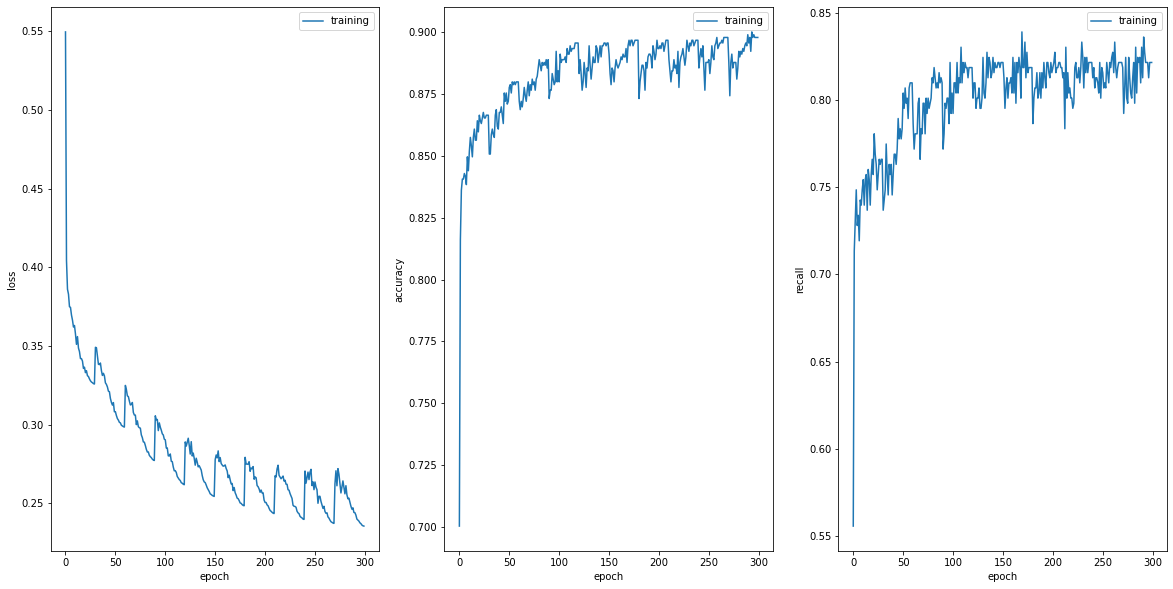

In [44]:
h = history.history
plt.figure(1, figsize=(20, 10))

plt.subplot(131)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(h['loss'], label='training')
plt.legend()

plt.subplot(132)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(h['accuracy'], label='training')
# plt.plot(h['val_acc'], label='validation')
plt.legend()

plt.subplot(133)
plt.xlabel('epoch')
plt.ylabel('recall')
plt.plot(h['recall'], label='training')
plt.legend()

plt.show()

In [45]:
models = Ensembling.load_ensemble()
members = list(reversed(models))
for model in members:
    score = model.evaluate(x = X_train_gridsearch, y = y_train)
#     print(score)

28/28 [==============================] - 0s 3ms/step - loss: 0.3257 - accuracy: 0.8664 - recall: 0.7661


In [46]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX, testY, treshhold):
    # make predictions
    yhats = [model.predict(testX) for model in members]
    yhats = np.array(yhats)
    # sum across ensemble members
    summed = np.sum(yhats, axis=0)
    # argmax across classes
    result = (summed>treshhold).astype(int)
    accuracy = roc_auc_score(testY, result)
    return result, accuracy

In [47]:
def evaluate_members(members, num_member):
    accuracy = []
    treshold = []
    for tr in tqdm(np.arange(1, num_member+1, 0.5)):
        res, acc = ensemble_predictions(members, X_train_gridsearch, y_train, tr)
        accuracy.append(acc)
        treshold.append(tr)
    best_tr_id = np.argmax(accuracy)
    best_tr_acc = accuracy[best_tr_id]
    best_tr = treshold[best_tr_id]
    return best_tr_acc, best_tr

In [48]:
def get_test_predictions(members,num_member, testX, treshold):
    
    yhats = [model.predict(testX) for model in members[:num_member]]
    yhats = np.array(yhats)
    # sum across ensemble members
    summed = np.sum(yhats, axis=0)
    # argmax across classes
    result = (summed>treshold).astype(int)
    return result

In [49]:
scores = []
tr = []
for i in range(2, 11):
    acc, best_tr = evaluate_members(members[:i], i)
    scores.append(acc)
    tr.append(best_tr)
best_n_model = np.argmax(scores)+2
best_treshhold = tr[np.argmax(scores)]
best_acc = np.max(scores)

print(best_n_model, best_acc, best_treshhold)

100%|██████████████████████████████████████████| 20/20 [00:32<00:00,  1.64s/it]

3 0.8866599559006807 1.0


In [50]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": get_test_predictions(members, best_n_model, X_test_gridsearch, best_treshhold).squeeze()
    })
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [51]:
submission.to_csv('submissions/submission_Keras_8.csv', index=False)